In [1]:
from pinpoint import VideoReader, Tracker
import matplotlib.pyplot as plt
import time
import h5py
import glob
import numpy as np
import cv2

In [2]:
videos = glob.glob("/Users/jake/Downloads/VID*.mp4")[::-1]
videos

['/Users/jake/Downloads/VID_20180801_002519.mp4',
 '/Users/jake/Downloads/VID_20180731_224959.mp4',
 '/Users/jake/Downloads/VID_20180731_222009.mp4']

In [3]:
video = VideoReader(videos[0])

In [4]:
frame_idx, frame = video.read()

In [5]:
frame_idx

0

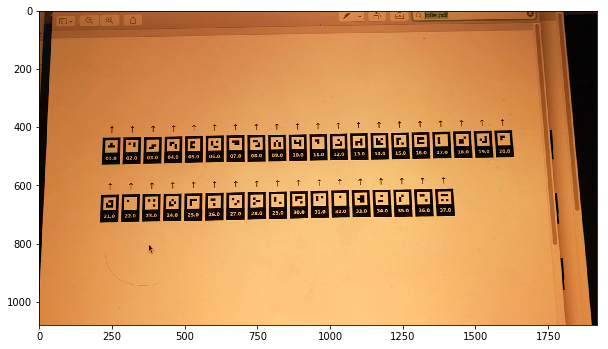

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(frame[...,::-1])
plt.show()

In [7]:
from pinpoint.utils import grayscale, adaptive_threshold, find_contours, find_candidate_barcodes, fit_polygon

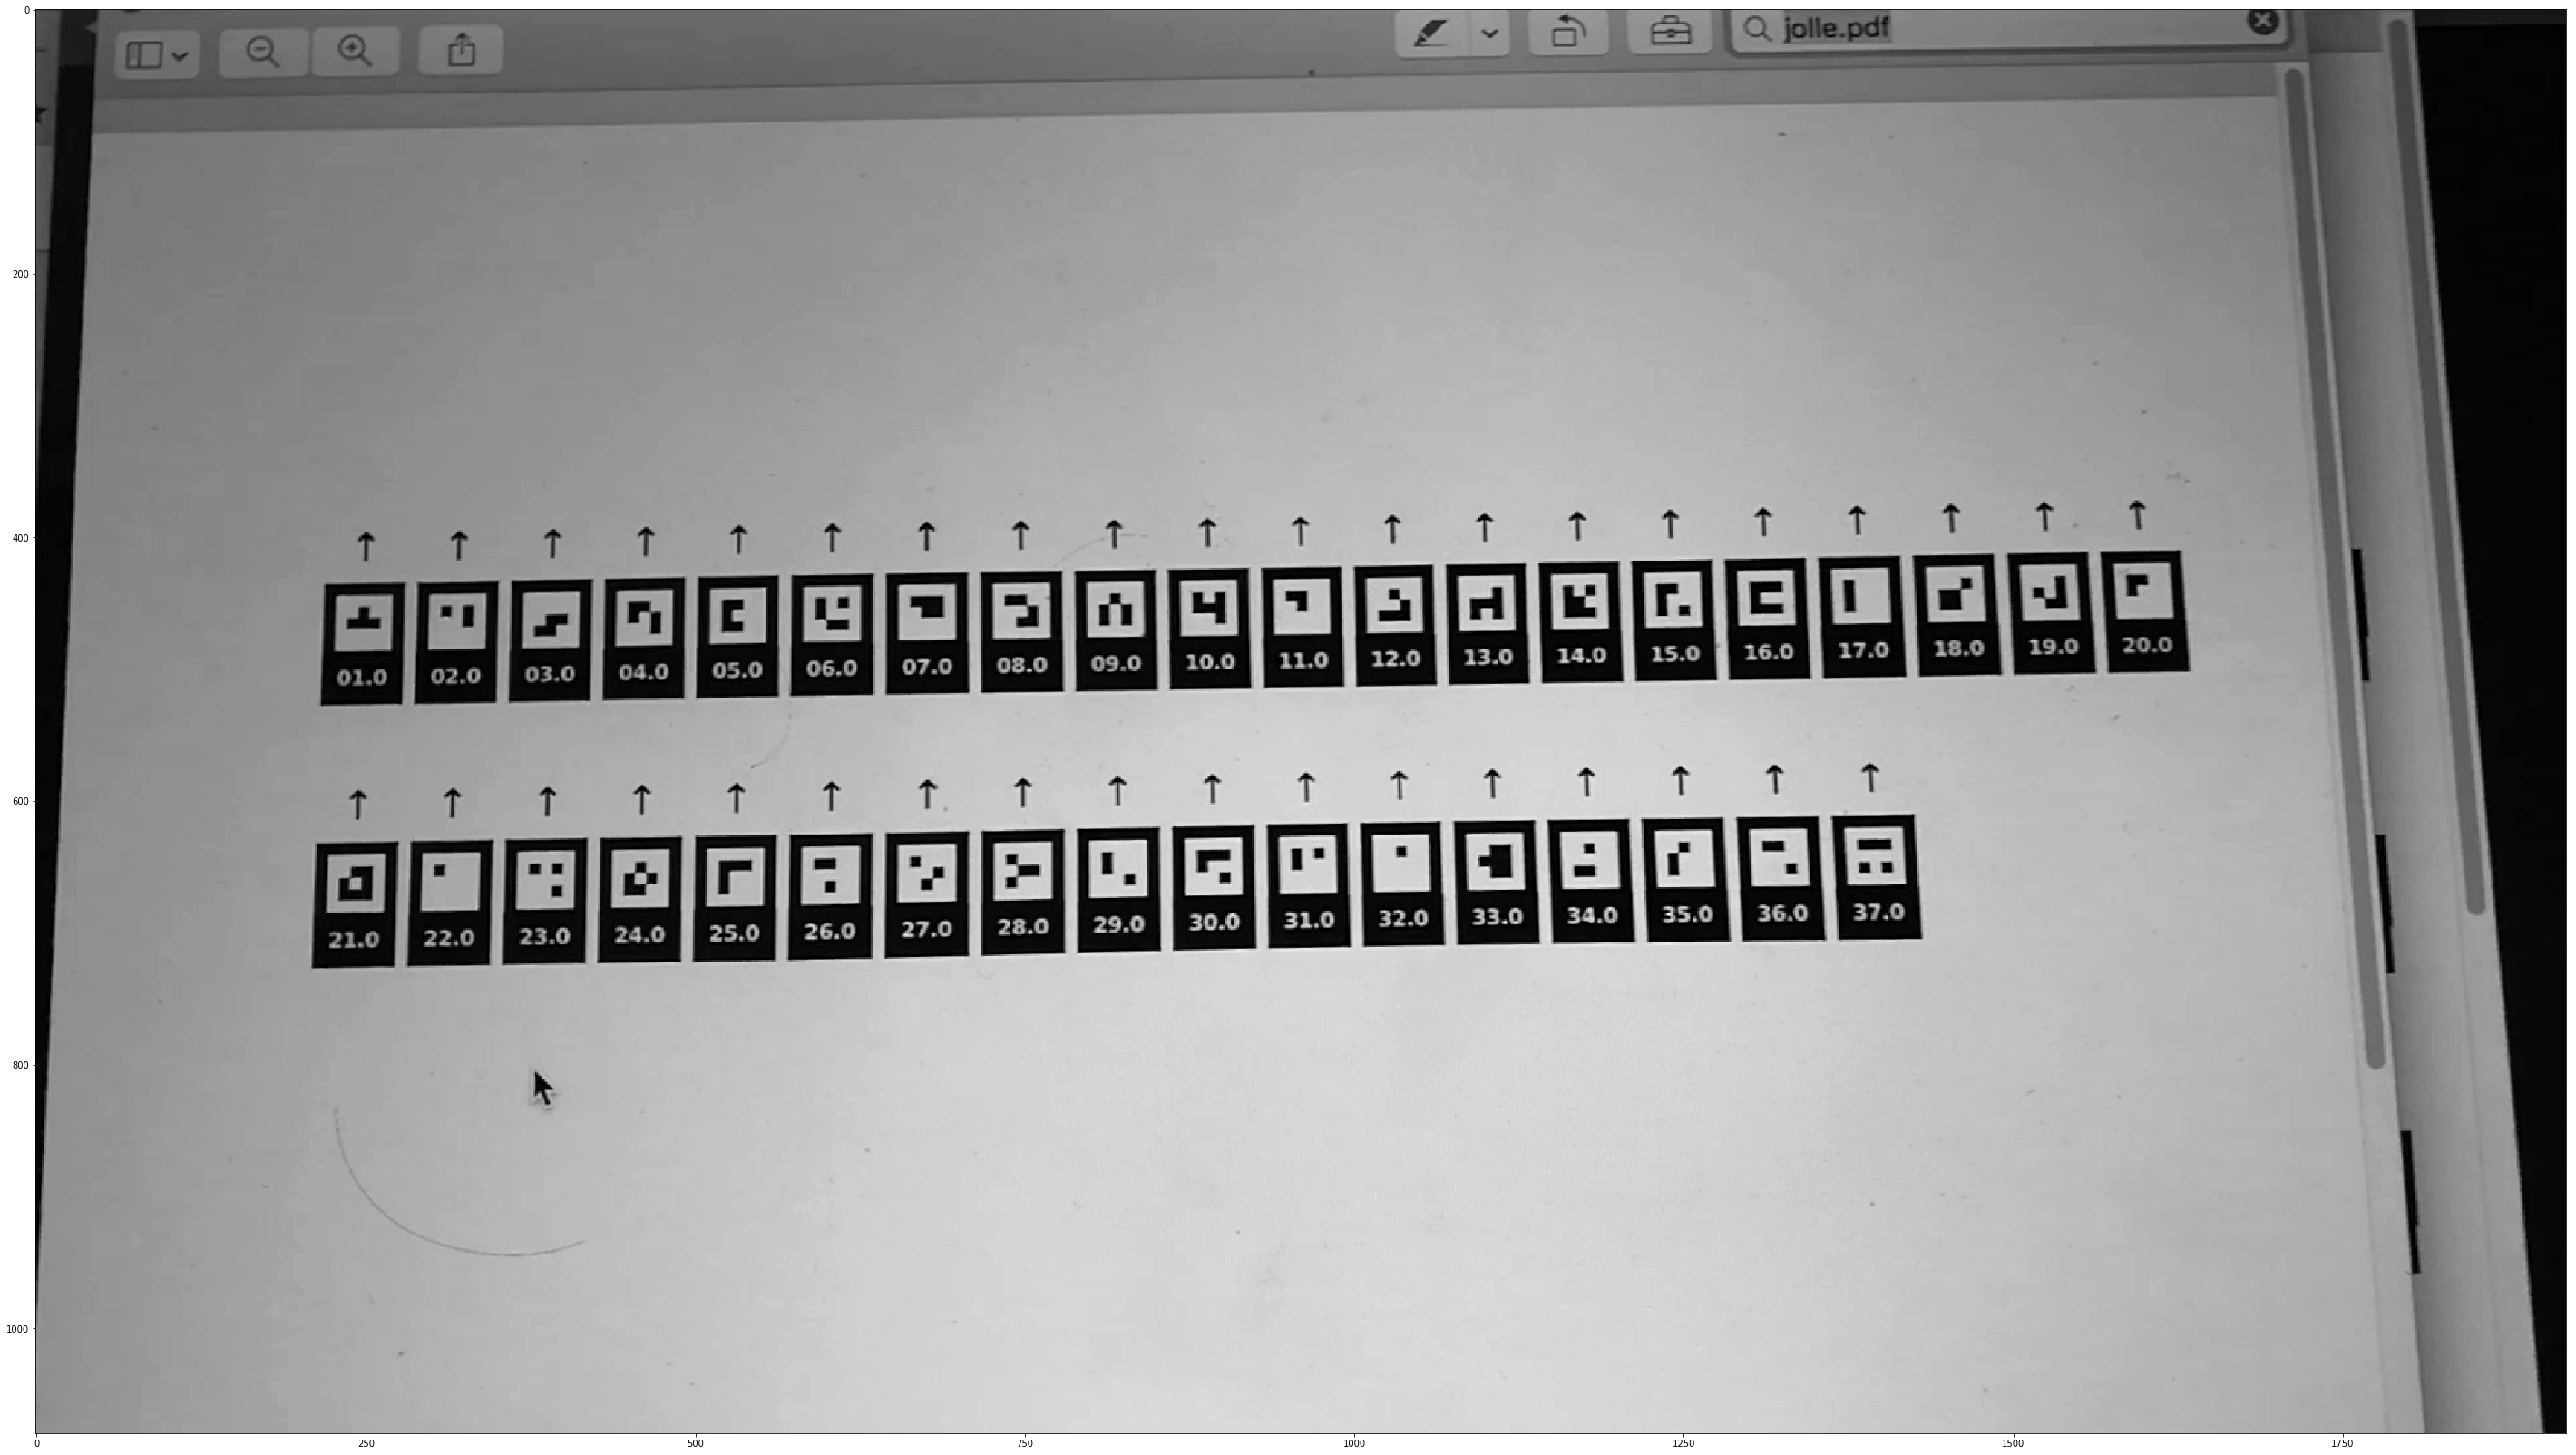

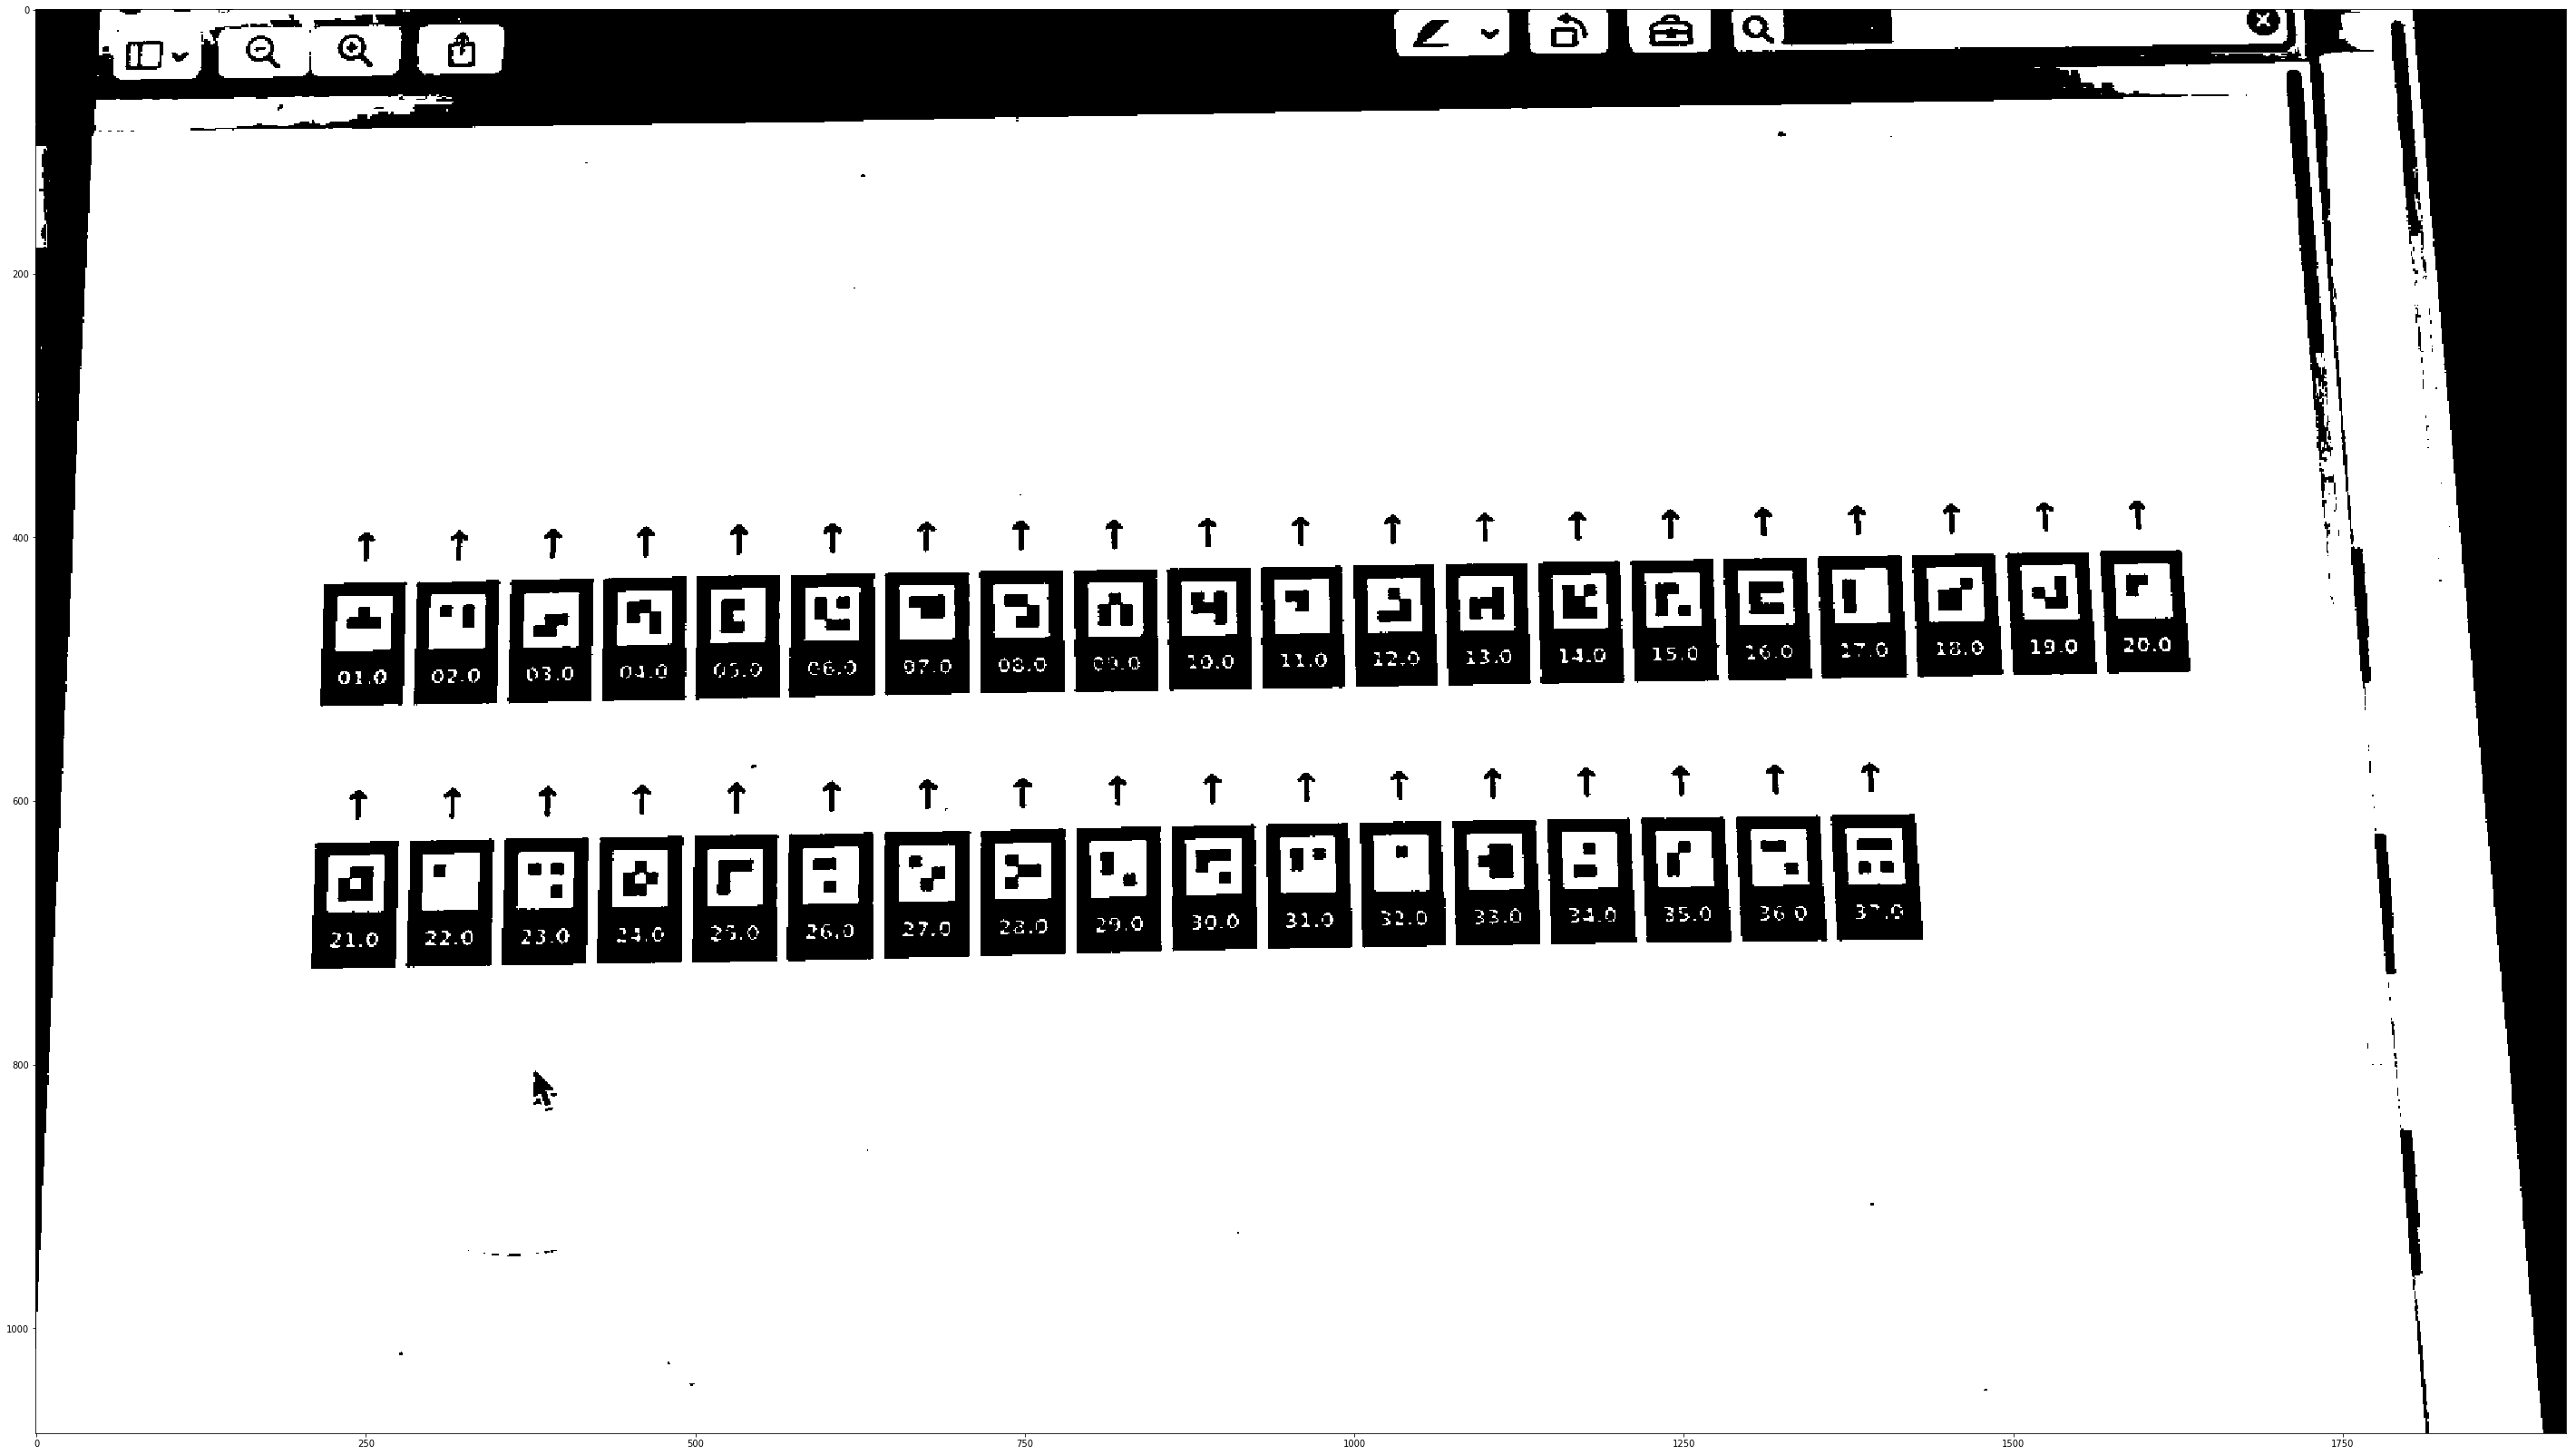

In [8]:
# modify these parameters to adjust the threshold
block_size = 1001
offset = 0
resize = 1

resized = cv2.resize(frame, (0,0), None, fx = resize, fy = resize)
gray = grayscale(resized, 1)
thresh = adaptive_threshold(gray, block_size, offset)

plt.figure(figsize=(50,50))
plt.imshow(gray, cmap='gray')
plt.show()

plt.figure(figsize=(50,50))
plt.imshow(thresh, cmap='gray')
plt.show()

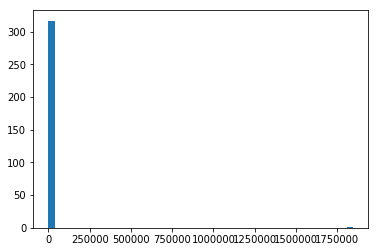

In [9]:
contours = find_contours(thresh)
areas = np.array(list(map(cv2.contourArea, contours)))
len(contours)

plt.hist(areas[areas>10], bins=50)
plt.show()

In [10]:
tracker = Tracker(source=VideoReader(videos[0], batch_size=100),
                  block_size=block_size,
                  offset=offset,
                  distance_threshold=20,
                  area_range=(500,150000),
                  tolerance=0.1,
                  channel=1,
                  resize=resize)

In [11]:
# set your barcode dictionary
tracker.load_dict('/Users/jake/Downloads/3x3_list.h5')

True

In [12]:
t0 = time.time()
tracker.track('output.h5', n_jobs=-1)
t1 = time.time()
dt = t1-t0


In [13]:
f = h5py.File('output.h5', 'r')

frames_idx = f['data/frames_idx'].value
corners = f['data/corners'].value
identity = f['data/identity'].value
distance = f['data/distance'].value

source = f.attrs['source']

f.close()

In [14]:
source

b'/Users/jake/Downloads/VID_20180801_002519.mp4'

In [15]:
frames_idx

array([  0,   0,   0, ..., 177, 177, 177])

In [16]:
np.unique(identity[distance == 0])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37], dtype=int32)

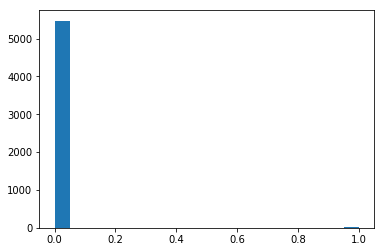

In [17]:
plt.hist(distance, bins=20)
plt.show()

In [18]:
class VideoWriter:

    def __init__(self, path, codec, fps, frame_size, color=True):
        codec = cv2.VideoWriter_fourcc(*codec)
        self.stream = cv2.VideoWriter(path, codec, fps, frame_size, color)

    def write(self, frame):
        self.stream.write(frame)

    def write_batch(self, batch):
        for frame in batch:
            self.write(frame)

    def close(self):
        self.stream.release()
        return not self.stream.isOpened()

In [19]:
n_tags = 38
cmap = plt.cm.nipy_spectral(np.linspace(0, 1, n_tags+1))[1:][:, :3][:, ::-1] * 255
cmap = cmap.astype(np.uint8)

In [20]:
reader = VideoReader(videos[0])
writer = VideoWriter('test.mp4', 'X264', 30.0, (1280, 720), True)
for idx in range(300):
    frame = reader.read()
    if frame is not None:
        frame_idx, frame = frame
        frame_corners = corners[(frames_idx == idx) & (distance == 0)].astype(int)
        frame_ids = identity[(frames_idx == idx) & (distance == 0)].astype(int)
        for ident, corner in zip(frame_ids,frame_corners):
            cv2.circle(frame, (corner[0,0], corner[0,1]), 10, (int(cmap[ident][0]), int(cmap[ident][1]), int(cmap[ident][2])), -1)
            cv2.circle(frame, (corner[1,0], corner[1,1]), 10, (int(cmap[ident][0]), int(cmap[ident][1]), int(cmap[ident][2])), 3)
        if type(frame) is not type(None):
            frame = cv2.resize(frame, (1280, 720))
        writer.write(frame)
    else:
        break
        
reader.close()
writer.close()

True